In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# Mean and standard deviation for MNIST dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mean,
                                     std = std)])

train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

dataiter = iter(train_loader)
images, labels = next(dataiter)
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
               "horse", "ship", "truck"]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.chan=False
        if in_channels==out_channels:
          self.chan=True
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True)
            )
        self.relu_fin=nn.ReLU(inplace=True)

    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out += self.shortcut(x)
        out=self.relu_fin(out)
        return out

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.layer1 = ResBlock(3, 16, stride=2)
        self.layer2 = ResBlock(16, 32, stride=2)
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

class CustomModel2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel2, self).__init__()
        self.layer1 = ResBlock(3, 16, stride=2)
        self.layer2 = ResBlock(16, 16, stride=1)
        self.layer3 = ResBlock(16, 32, stride=2)
        self.layer4 = ResBlock(32, 32, stride=1)
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [ ]:
def compute_accuracy(model,loader_):
  test_acc=0
  model.eval()
  model.to(device)
  total_samples = 0
  with torch.no_grad():
      #Iterating over the training dataset in batches
      for i, (images, labels) in enumerate(loader_):
          images = images.to(device)
          y_true = labels.to(device)
          #Calculating outputs for the batch being iterated
          outputs = model(images)
          #Calculated prediction labels from models
          _, y_pred = torch.max(outputs.data, 1)
          total_samples+=labels.size(0)
          #Comparing predicted and true labels
          test_acc += (y_pred == y_true).sum().item()
          # print((y_pred == y_true).sum().item())
  # print(total_samples)
  acc=(100 * test_acc / total_samples)
  return acc

In [ ]:
model = CustomModel().to(device)
model2 = CustomModel2().to(device)

epochs = 50
learning_rate = 0.001
# weight_decay = 0  # L2 regularization factor
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_accs = []
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_accs.append(compute_accuracy(model, train_loader))

    train_losses.append(train_loss/len(train_loader))
    if epoch%5==0:
        print(f'Epoch {epoch+1}/{epochs}:', end=' ')
        print(f"Training loss = {train_losses[-1]}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50: Training loss = 1.4331031294582446
Epoch 6/50: Training loss = 0.5108396912665318
Epoch 11/50: Training loss = 0.1324870600984396
Epoch 16/50: Training loss = 0.07046577620648724
Epoch 21/50: Training loss = 0.06892568650319005
Epoch 26/50: Training loss = 0.05418229836043414
Epoch 31/50: Training loss = 0.053587382698617396
Epoch 36/50: Training loss = 0.04728593689143447
Epoch 41/50: Training loss = 0.05078826095555168
Epoch 46/50: Training loss = 0.04407592824746176


Test accuracy of ResNet = 65.57


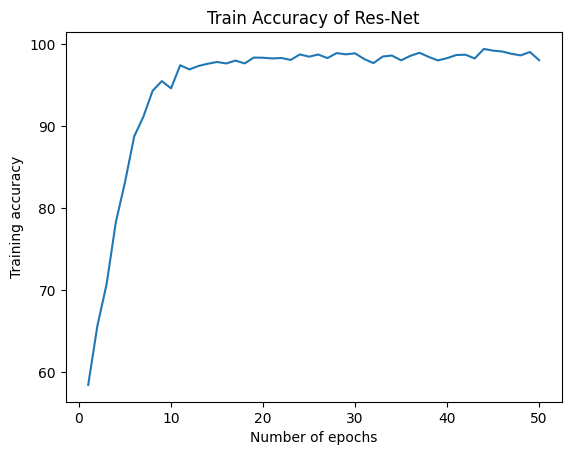

In [ ]:
#Plotting accuracy for all epochs
plt.plot(range(1,epochs+1), train_accs)
plt.title("Train Accuracy of Res-Net")
plt.xlabel("Number of epochs")
plt.ylabel("Training accuracy")

print(f"Test accuracy of ResNet = {compute_accuracy(model, test_loader)}")

In [ ]:
#parameters of resnet model
total_params_resnet = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters for resnet model: {total_params_resnet}")

Total number of parameters for resnet model: 544378


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
const_factor = 0
lr_recon = 0.1

In [ ]:
adversarial_inp = torch.randn((1,3,32,32))
adversarial_class = 2
adversarial_inp = adversarial_inp.to(device)
print(adversarial_inp.shape)
initial_inp = adversarial_inp
print(model(adversarial_inp))

tensor([[-11.5743, -12.0693,  -5.6300, -11.3947,  -5.4369,  -8.2508,   8.8960,
          -2.0355,  -5.7958,   1.8538]], device='cuda:0')


In [ ]:
# label = torch.zeros((1))
# label = label.to(device)
# Enable gradient calculation for input
adversarial_inp.requires_grad = True
for epoch in range(1000):
    train_loss = 0
    model.train()
    outputs = model(adversarial_inp)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    # loss = criterion(outputs, label)
    loss = 1-outputs[0][adversarial_class]+const_factor
    optimizer.zero_grad()
    loss.backward()
    print(adversarial_inp.grad.shape)
    with torch.no_grad():
        adversarial_inp -= learning_rate * adversarial_inp.grad
        adversarial_inp.grad.zero_()  # Clear the gradients
    train_loss = loss.item()
    print(f'Epoch {epoch+1}/{2}:', end=' ')
    print(f"Training loss = {train_loss}")

torch.Size([1, 3, 32, 32])
Epoch 1/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 2/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 3/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 4/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 5/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 6/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 7/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 8/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 9/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 10/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 11/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 12/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 13/2: Training loss = 0.9999995231628418
torch.Size([1, 3, 32, 32])
Epoch 14/2: Training

In [ ]:
print(model(adversarial_inp))

In [ ]:
print(adversarial_inp)

tensor([[[[-0.9992, -0.5578, -0.5430,  ..., -1.3379,  0.5084, -0.8026],
          [-1.7341,  0.2474, -1.1544,  ...,  0.9972,  0.1437, -0.1446],
          [-0.6148, -1.5673, -0.1268,  ..., -0.2293, -1.2468,  0.3253],
          ...,
          [ 0.6331, -0.5949, -0.7831,  ..., -1.7946, -0.7792,  0.0130],
          [ 0.6276,  0.7725, -0.5600,  ...,  1.2132,  1.6616,  2.2940],
          [ 1.2265, -0.2243, -0.8309,  ..., -1.0965, -0.1226,  0.7563]],

         [[-1.3819,  2.4281,  0.0081,  ..., -3.4330,  0.1247,  0.8030],
          [ 0.8899, -2.1040, -0.9181,  ...,  0.6441, -1.6056,  1.4198],
          [-2.1779, -0.5951, -0.5865,  ..., -0.1101,  1.6728,  0.5141],
          ...,
          [-0.5806, -0.8980,  1.8310,  ...,  1.1931, -0.6869, -0.3352],
          [-0.0108, -1.1504, -0.5974,  ..., -0.2070,  0.2568, -1.9915],
          [-1.0474,  0.6127,  1.3162,  ..., -0.0656, -1.5717,  0.1075]],

         [[ 0.7897, -1.7247, -0.4775,  ..., -1.1444, -0.2050,  1.1382],
          [-0.3310,  0.1175, -

In [ ]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

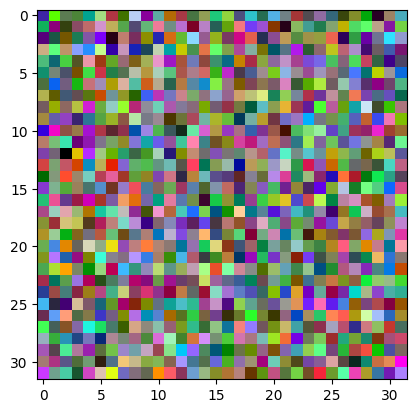

In [ ]:
#Reconstructed adversarial class image
reconstructed_image = adversarial_inp.clone().detach().cpu()
reconstructed_image = unnormalize(reconstructed_image[0], mean, std)
plt.imshow(reconstructed_image.numpy().transpose(1,2,0))

Class 0: Loss = 1.0


Class 1: Loss = 1.0


Class 2: Loss = 1.0


Class 3: Loss = 1.0


Class 4: Loss = 1.0


Class 5: Loss = 1.0


Class 6: Loss = 0.0


Class 7: Loss = 1.0


Class 8: Loss = 1.0


Class 9: Loss = 1.0


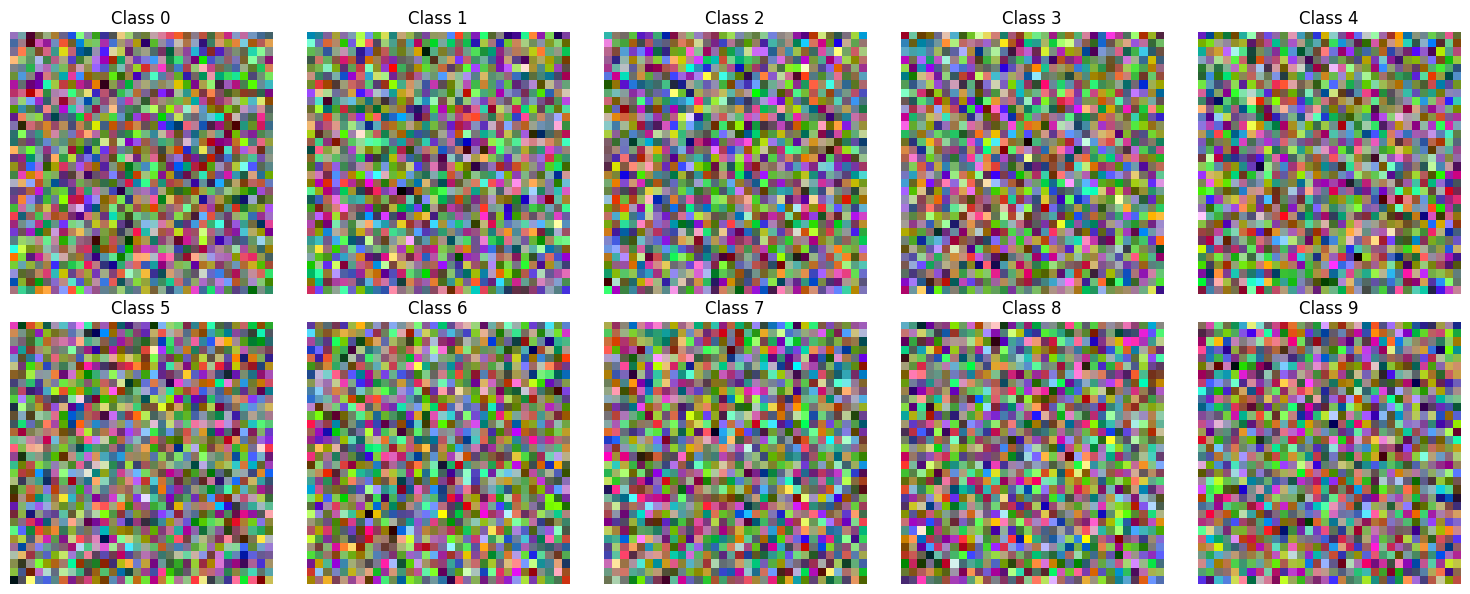

In [ ]:
#Comparing produced images along with losses for all the cifar-10 classes(all above steps included)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for adversarial_class in range(10):
    adversarial_inp = torch.randn((1,3,32,32))
    adversarial_inp = adversarial_inp.to(device)

    adversarial_inp.requires_grad = True
    for epoch in range(1000):
        train_loss = 0
        model.train()
        outputs = model(adversarial_inp)
        outputs = torch.nn.functional.softmax(outputs, dim=1)
        # loss = criterion(outputs, label)
        loss = 1-outputs[0][adversarial_class]+const_factor
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            adversarial_inp -= learning_rate * adversarial_inp.grad
            adversarial_inp.grad.zero_()  # Clear the gradients
        train_loss = loss.item()
    print(f'Class {adversarial_class}: Loss = {train_loss}')
    reconstructed_image = adversarial_inp.clone().detach().cpu()
    reconstructed_image = unnormalize(reconstructed_image[0], mean, std)
    reconstructed_image = reconstructed_image.numpy().transpose(1,2,0)
    ax = axes[adversarial_class // 5, adversarial_class % 5]
    ax.imshow(reconstructed_image)
    ax.set_title(f'Class {adversarial_class}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Problem is that even for inputs producing very small values of loss function the image seems like a lucky noisy one**

**Could be due to overfitting, tried L2 regularization but it didn't help at all**

**Trying to reconstruct obfuscated image by output class information**

In [ ]:
for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        break
print(images[0].shape)

torch.Size([3, 32, 32])


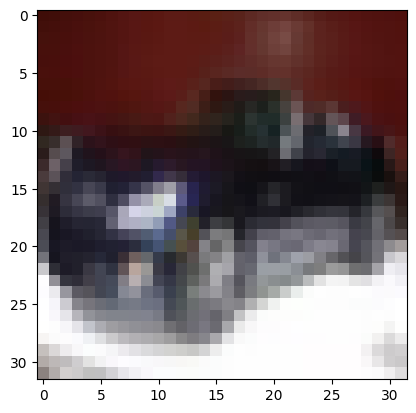

In [ ]:
plt.imshow(unnormalize(images[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of original image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(images)[0],dim=0))
  adversarial_class = torch.argmax(model(images)[0]).item()
  print(adversarial_class)

tensor([3.9308e-19, 1.0000e+00, 1.0120e-17, 5.6416e-07, 6.4227e-19, 2.4389e-15,
        1.3633e-16, 4.1573e-23, 2.6947e-32, 5.7073e-16], device='cuda:0')
1


**Identified 3 levels of obfuscation 0.1,0.4 and 1(standard devns)**

**First for 0.1**

In [ ]:
#Obfuscating Image by adding noise
std_noise = .1
mean_noise = 0
tmp = images[0].clone()
tmp = tmp + (torch.randn(tmp.size()) * std_noise + mean_noise).to(device)
tmp = tmp.unsqueeze(0)

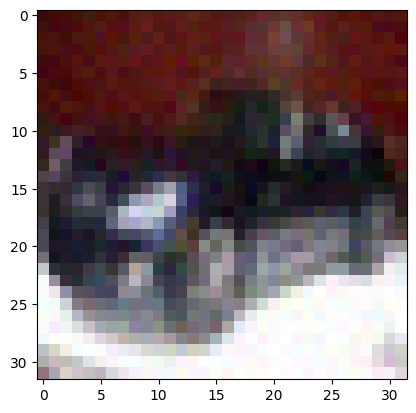

In [ ]:
plt.imshow(unnormalize(tmp[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of obfuscated image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(tmp)[0],dim=0))
  print(torch.argmax(model(tmp)).item())

tensor([4.8284e-20, 1.0000e+00, 7.1057e-18, 1.1037e-06, 4.9583e-19, 5.0958e-15,
        6.2544e-17, 2.1623e-23, 1.7707e-32, 1.5129e-16], device='cuda:0')
1


Class 1: Loss = 1.0728836059570312e-06


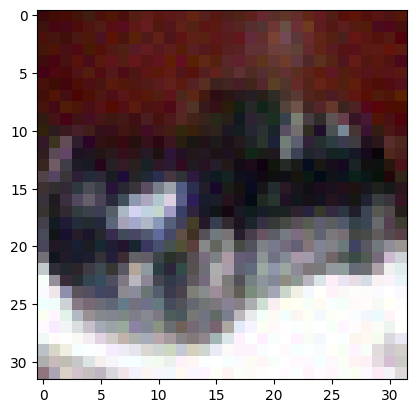

In [ ]:
adversarial_inp = tmp
adversarial_inp.requires_grad = True
learning_rate = 0.1
const_factor = 0
for epoch in range(1000):
    train_loss = 0
    model.train()
    outputs = model(adversarial_inp)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    # loss = criterion(outputs, label)
    loss = 1-outputs[0][adversarial_class]+const_factor
    optimizer.zero_grad()
    loss.backward()
    with torch.no_grad():
        adversarial_inp -= learning_rate * adversarial_inp.grad
        adversarial_inp.grad.zero_()  # Clear the gradients
    train_loss = loss.item()
print(f'Class {adversarial_class}: Loss = {train_loss}')
reconstructed_image = adversarial_inp.clone().detach().cpu()
plt.imshow(unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

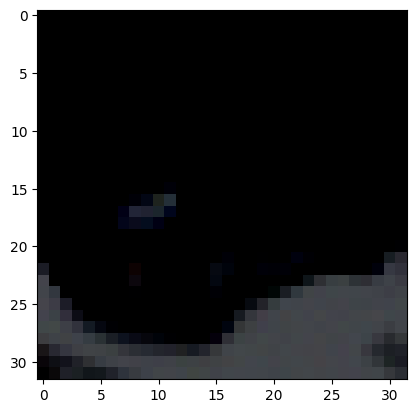

In [ ]:
#Difference between original and reconstructed image
plt.imshow(unnormalize(images[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0)-unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of reconstructed image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(adversarial_inp)[0],dim=0))
  print(torch.argmax(model(adversarial_inp)).item())

tensor([4.5924e-20, 1.0000e+00, 6.8195e-18, 1.0367e-06, 4.7680e-19, 4.8670e-15,
        6.1387e-17, 2.0693e-23, 1.7074e-32, 1.4980e-16], device='cuda:0')
1


**Next for 0.4**

In [ ]:
#Obfuscating Image by adding noise
std_noise = .4
mean_noise = 0
tmp = images[0].clone()
tmp = tmp + (torch.randn(tmp.size()) * std_noise + mean_noise).to(device)
tmp = tmp.unsqueeze(0)

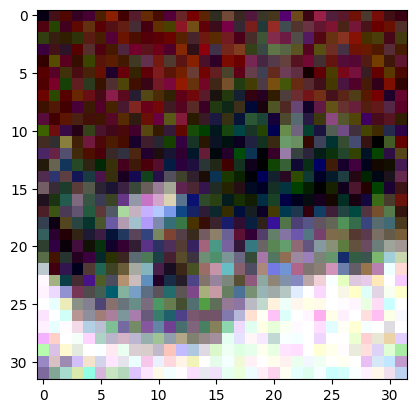

In [ ]:
plt.imshow(unnormalize(tmp[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of obfuscated image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(tmp)[0],dim=0))
  print(torch.argmax(model(tmp)).item())

tensor([4.7141e-21, 1.3972e-06, 8.1702e-13, 9.9956e-01, 1.7410e-08, 4.3776e-04,
        1.2083e-16, 9.9455e-12, 1.2953e-24, 5.0875e-12], device='cuda:0')
3


Class 1: Loss = 1.6689300537109375e-06


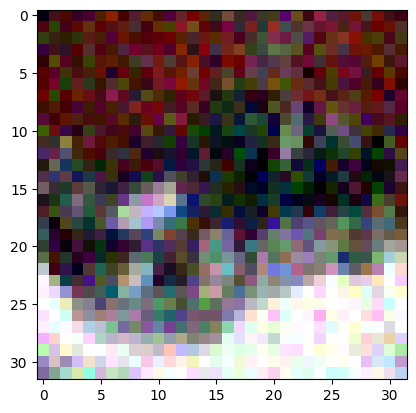

In [ ]:
adversarial_inp = tmp
adversarial_inp.requires_grad = True
learning_rate = 0.5
const_factor = 0
for epoch in range(1000):
    train_loss = 0
    model.train()
    outputs = model(adversarial_inp)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    # loss = criterion(outputs, label)
    loss = 1-outputs[0][adversarial_class]+const_factor
    optimizer.zero_grad()
    loss.backward()
    with torch.no_grad():
        adversarial_inp -= learning_rate * adversarial_inp.grad
        adversarial_inp.grad.zero_()  # Clear the gradients
    train_loss = loss.item()
print(f'Class {adversarial_class}: Loss = {train_loss}')
reconstructed_image = adversarial_inp.clone().detach().cpu()
plt.imshow(unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

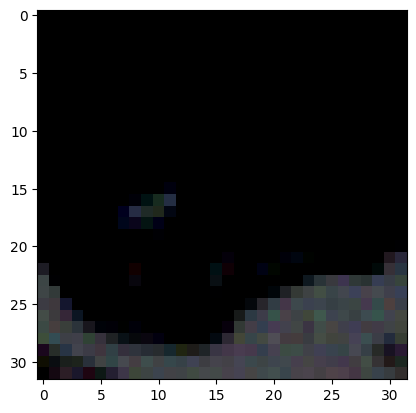

In [ ]:
#Difference between original and reconstructed image
plt.imshow(unnormalize(images[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0)-unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of reconstructed image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(adversarial_inp)[0],dim=0))
  print(torch.argmax(model(adversarial_inp)).item())

tensor([5.4544e-24, 1.0000e+00, 1.7689e-13, 8.9971e-07, 1.3462e-10, 6.5950e-07,
        4.1911e-14, 1.7366e-14, 2.7815e-26, 5.4957e-09], device='cuda:0')
1


**Image has been successfully reconstructed with an optimal learning rate**

**Now we shall try for a highly obfuscated image**

In [ ]:
#Obfuscating Image by adding noise
std_noise = 1
mean_noise = 0
tmp = images[0].clone()
tmp = tmp + (torch.randn(tmp.size()) * std_noise + mean_noise).to(device)
tmp = tmp.unsqueeze(0)

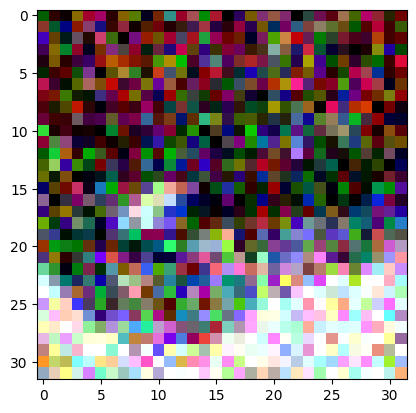

In [ ]:
plt.imshow(unnormalize(tmp[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of obfuscated image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(tmp)[0],dim=0))
  print(torch.argmax(model(tmp)).item())

tensor([1.3308e-19, 1.2780e-03, 8.2593e-05, 4.7210e-06, 1.5445e-07, 9.9682e-01,
        1.8106e-03, 6.1662e-18, 4.8796e-32, 7.6318e-18], device='cuda:0')
5


Class 1: Loss = 0.0


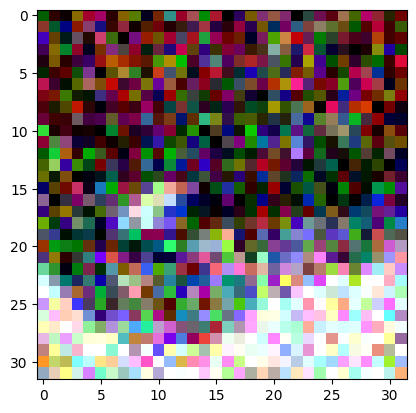

In [ ]:
adversarial_inp = tmp
adversarial_inp.requires_grad = True
learning_rate = 0.5
const_factor = 0
for epoch in range(1000):
    train_loss = 0
    model.train()
    outputs = model(adversarial_inp)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    # loss = criterion(outputs, label)
    loss = 1-outputs[0][adversarial_class]+const_factor
    optimizer.zero_grad()
    loss.backward()
    with torch.no_grad():
        adversarial_inp -= learning_rate * adversarial_inp.grad
        adversarial_inp.grad.zero_()  # Clear the gradients
    train_loss = loss.item()
print(f'Class {adversarial_class}: Loss = {train_loss}')
reconstructed_image = adversarial_inp.clone().detach().cpu()
plt.imshow(unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

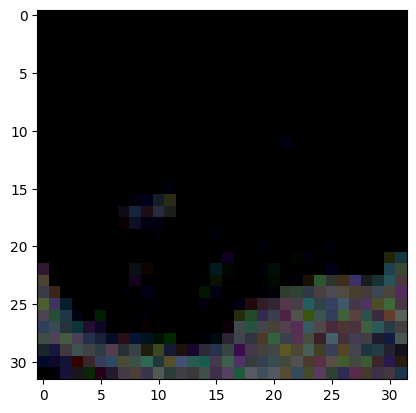

In [ ]:
#Difference between original and reconstructed image
plt.imshow(unnormalize(images[0].clone().detach().cpu(), mean, std).numpy().transpose(1,2,0)-unnormalize(reconstructed_image[0], mean, std).numpy().transpose(1,2,0))

In [ ]:
#Output of reconstructed image
with torch.no_grad():
  print(torch.nn.functional.softmax(model(adversarial_inp)[0],dim=0))
  print(torch.argmax(model(adversarial_inp)).item())

tensor([1.3374e-33, 1.0000e+00, 1.7208e-24, 2.2224e-23, 2.8337e-23, 9.7108e-25,
        1.7574e-14, 3.3972e-31, 1.3987e-38, 1.6560e-16], device='cuda:0')
1


**Even if we get a good loss convergence, the output image is still very noisy**

**In conclusion, a reconstruction attack can successfully take place on lightly and moderately obfuscated images, but on heavily obfuscated ones the standard algorithm is not strong enough to reconstruct the original image, instead we end up with a noisy image that is biased towards that particular class**

**This could be because the trained model is weak and overfits the data, so there is no constricted input space for each class**

**It could also be because of the small number of output classes**